## River Arno level Prediction

### Step 1 : Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesRegressor

import math
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### Step 2 : Importing the dataset

In [2]:
data = pd.read_csv('River_Arno.csv')

### Step 3 : Exploring the dataset

In [3]:
data.head()

,Date,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Rainfall_Vernio,Rainfall_Stia,Rainfall_Consuma,Rainfall_Incisa,Rainfall_Montevarchi,Rainfall_S_Savino,Rainfall_Laterina,Rainfall_Bibbiena,Rainfall_Camaldoli,Temperature_Firenze,Hydrometry_Nave_di_Rosano
0,01/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.82
1,02/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.94
2,03/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.11
3,04/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.84
4,05/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.88


In [4]:
data.dtypes

Date                          object
Rainfall_Le_Croci            float64
Rainfall_Cavallina           float64
Rainfall_S_Agata             float64
Rainfall_Mangona             float64
Rainfall_S_Piero             float64
Rainfall_Vernio              float64
Rainfall_Stia                float64
Rainfall_Consuma             float64
Rainfall_Incisa              float64
Rainfall_Montevarchi         float64
Rainfall_S_Savino            float64
Rainfall_Laterina            float64
Rainfall_Bibbiena            float64
Rainfall_Camaldoli           float64
Temperature_Firenze          float64
Hydrometry_Nave_di_Rosano    float64
dtype: object

In [5]:
from datetime import datetime,date
data['Date'] = pd.to_datetime(data.Date, format = '%d/%m/%Y') #to change the time format from 01/01/1998 to 1998-01-01

In [6]:
missing = data.isnull().sum() #to find the total no.of Rows in each column which is NaN
missingdata = (missing/len(data['Date']))*100 #divide the missing rows/total date rows
print(missingdata)

Date                          0.000000
Rainfall_Le_Croci            26.664233
Rainfall_Cavallina           26.664233
Rainfall_S_Agata             26.664233
Rainfall_Mangona             26.664233
Rainfall_S_Piero             26.664233
Rainfall_Vernio              47.876354
Rainfall_Stia                84.386029
Rainfall_Consuma             84.386029
Rainfall_Incisa              44.407935
Rainfall_Montevarchi         79.956188
Rainfall_S_Savino            84.386029
Rainfall_Laterina            84.386029
Rainfall_Bibbiena            71.059998
Rainfall_Camaldoli           84.386029
Temperature_Firenze          24.644031
Hydrometry_Nave_di_Rosano     0.584155
dtype: float64


Text(0.5, 1.0, 'Fig 1 - Missing Values')

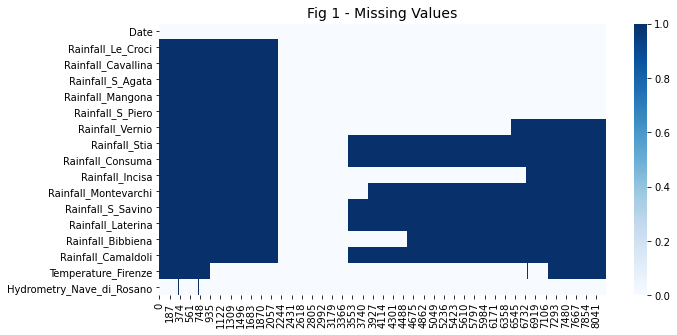

In [7]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,5))
sns.heatmap(data.T.isna(),cmap='Blues')
ax.set_title('Fig 1 - Missing Values',fontsize=14)

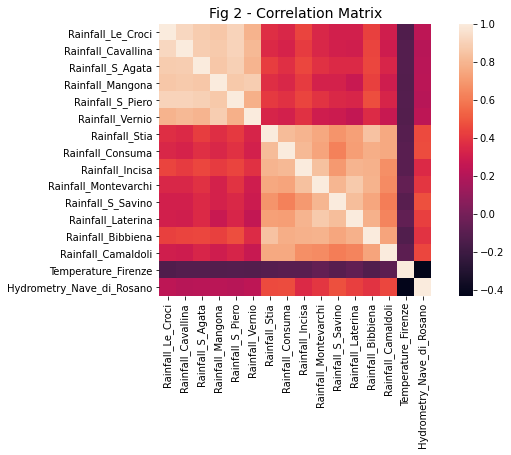

In [8]:
fig,ax = plt.subplots(figsize=(10,5))
ax.set_title('Fig 2 - Correlation Matrix',fontsize=14)
ax = sns.heatmap(data.corr(),square=True)

### Step 4 : Data Preprocessing

* Here,we used <b>ExtraTreesRegressor</b> model to do the regression, because it tends to be more robust than a simple linear regression.
It was decided to select the 3 best rain points with the objective of increasing the generalization capacity of LSTM.

* To apply the RFE we eliminate all the missing data and use the first 67% rows of the data, in order to avoid overfitting in the future LSTM model. This same data will be used to train the neural network later.

* Cross-validation will not be used on this notebook, the data was divided as follows:

-> Training data: 01/01/2004 to 05/05/2006 (854 days)

-> Test data: 06/05/2006 to 07/07/2007 (422 days)

RFE : Recursive Feature Elimination
LSTM :  Long Short-Term Memory


In [9]:
data = data.dropna() #remove the missing rows which has the value NaN
data = data.reset_index(drop=True) #sets a list of integer ranging from 0 to length of data as index.
train_size=0.67

In [10]:
rfe_train_test = int(len(data)*train_size) #make subdata for training test
rfe_train,rfe_test = data[0:rfe_train_test-1], data[rfe_train_test:len(data)] # assigning the values
data.loc[:rfe_train_test-1]

,Date,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Rainfall_Vernio,Rainfall_Stia,Rainfall_Consuma,Rainfall_Incisa,Rainfall_Montevarchi,Rainfall_S_Savino,Rainfall_Laterina,Rainfall_Bibbiena,Rainfall_Camaldoli,Temperature_Firenze,Hydrometry_Nave_di_Rosano
0,2004-01-01,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,8.65,1.84
1,2004-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,7.10,1.93
2,2004-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.2,0.0,5.50,1.61
3,2004-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.55,1.35
4,2004-01-05,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.70,1.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
849,2006-05-01,0.4,0.4,0.0,0.0,0.6,0.0,0.8,2.4,0.0,1.0,23.0,4.0,1.2,2.2,16.85,1.54
850,2006-05-02,0.2,0.0,0.0,1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.55,1.70
851,2006-05-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.6,18.30,1.60
852,2006-05-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.15,1.49


In [11]:
data.loc[rfe_train_test:len(data)]

,Date,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Rainfall_Vernio,Rainfall_Stia,Rainfall_Consuma,Rainfall_Incisa,Rainfall_Montevarchi,Rainfall_S_Savino,Rainfall_Laterina,Rainfall_Bibbiena,Rainfall_Camaldoli,Temperature_Firenze,Hydrometry_Nave_di_Rosano
854,2006-05-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.60,1.34
855,2006-05-07,1.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.30,1.15
856,2006-05-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.8,0.0,0.0,0.0,0.0,0.0,2.2,17.20,1.24
857,2006-05-09,56.0,54.6,45.0,30.8,42.0,24.0,9.6,16.6,8.8,14.2,2.6,15.6,19.6,16.0,15.45,1.63
858,2006-05-10,0.0,0.0,0.0,0.0,0.0,0.0,0.2,1.6,5.0,0.2,2.0,0.0,0.8,0.8,16.20,1.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271,2007-07-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.80,0.99
1272,2007-07-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.15,1.01
1273,2007-07-04,0.0,0.0,0.8,1.0,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.60,1.03
1274,2007-07-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.90,1.02


In [12]:
rfe_test = data.drop(['Date', 'Temperature_Firenze'], axis=1) #drop Date,Temperature_Firenze column
estimator = ExtraTreesRegressor() #called TreeRegressor Model

y_test_feature = rfe_test['Hydrometry_Nave_di_Rosano']
X_test_feature = rfe_test.drop('Hydrometry_Nave_di_Rosano', axis=1)

selector = RFE(estimator, n_features_to_select=1, step=1)
selector = selector.fit(X_test_feature.values, y_test_feature) #fitting of the model from test data

select1 = pd.DataFrame(selector.ranking_, columns=['Ranking']) #sorting for column Ranking

best_rainfall_1 = rfe_test.columns[select1.index[select1['Ranking'] == 1][0]]
best_rainfall_2 = rfe_test.columns[select1.index[select1['Ranking'] == 2][0]]
best_rainfall_3 = rfe_test.columns[select1.index[select1['Ranking'] == 3][0]]

print(f'Best rainfall region: {best_rainfall_1}')
print(f'Second best rainfall region: {best_rainfall_2}')
print(f'Third best rainfall region: {best_rainfall_3}')

Best rainfall region: Rainfall_Bibbiena
Second best rainfall region: Rainfall_Consuma
Third best rainfall region: Rainfall_S_Savino


### Feature Enginerring 

* Rainfall Seasonal = The seasonal component of Rainfall

* Rainfall Trend = The trend component of the Rainfall

* Temperature Seasonal = The seasonal component of Temperature

* Temperature Trend = The trend component of the Temperature

* Hydrometry Seasonal = The seasonal component of Hydrometry

* Hydrometry Trend = The trend component of the Hydrometry

* Hydrometry Next Day = The target variable, Hydrometry Nave di Rosano   of the next day (D+1)

In [13]:
data['Rainfall'] = data[best_rainfall_1]+data[best_rainfall_2]+data[best_rainfall_3]

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
df = data[['Date', 'Rainfall', 'Temperature_Firenze', 'Hydrometry_Nave_di_Rosano']]
pd.options.mode.chained_assignment = None  # default='warn'
df['Hydrometry_Next_Day'] = df['Hydrometry_Nave_di_Rosano'].shift(-1)
decompose_columns =  ['Rainfall', 'Temperature_Firenze', 'Hydrometry_Nave_di_Rosano']

for column in decompose_columns:
    decompose_data = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_Trend"] = decompose_data.trend
    df[f"{column}_Seasonal"] = decompose_data.seasonal

df = df.dropna()
df = df.reset_index(drop=True)

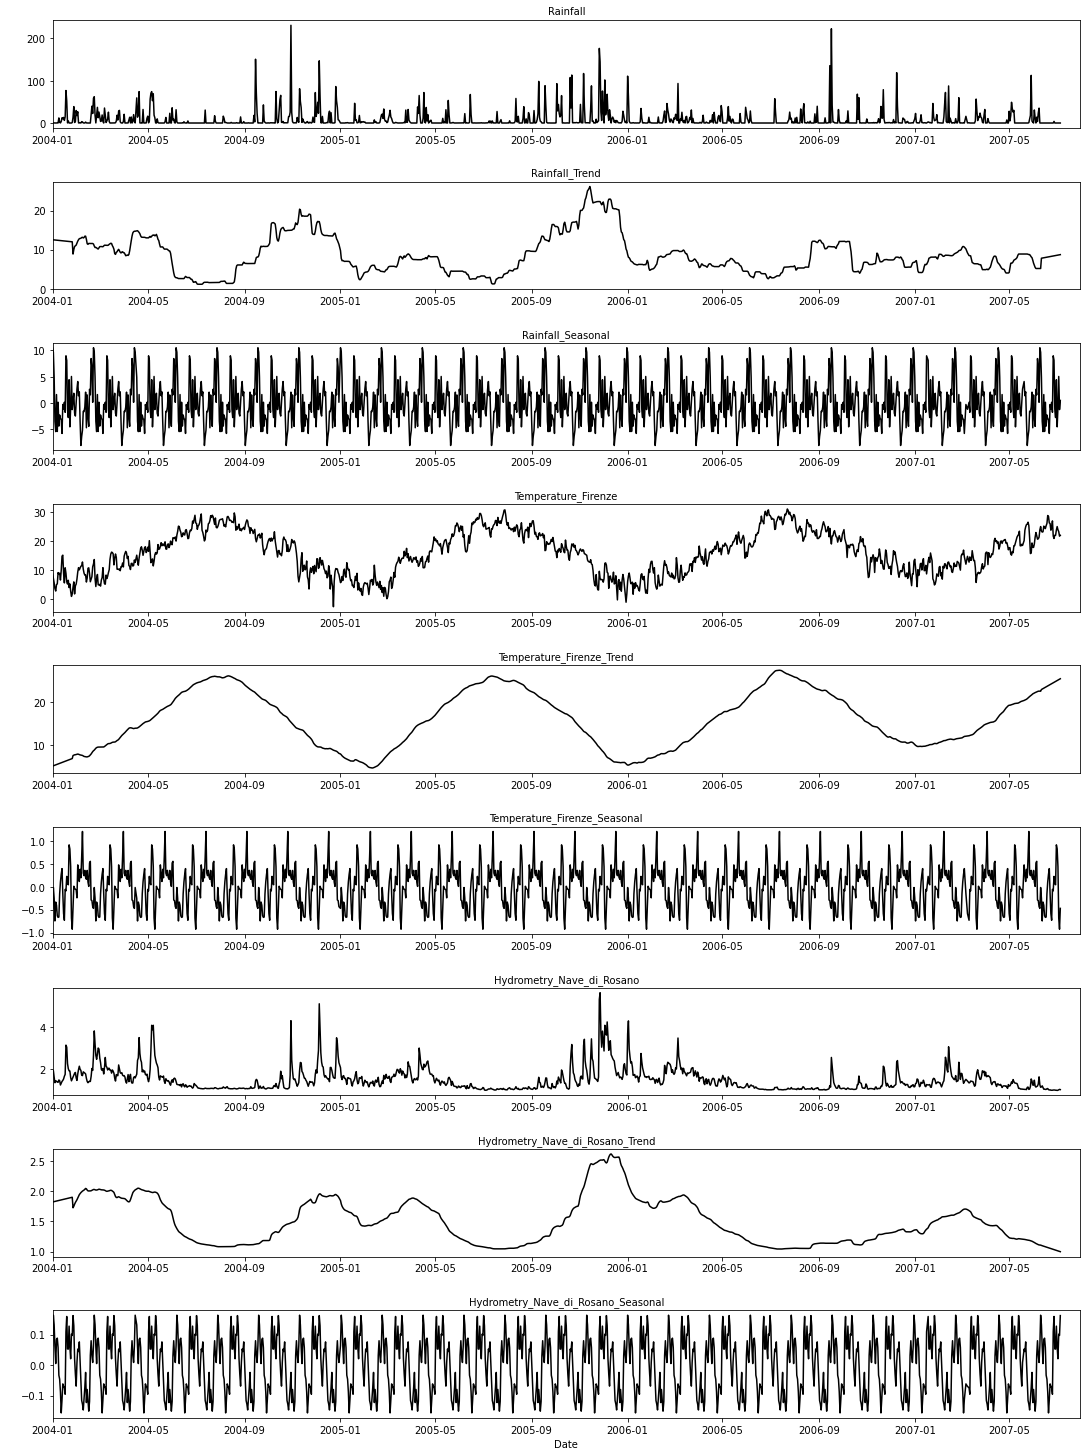

In [15]:
f, ax = plt.subplots(nrows=9, ncols=1, figsize=(15, 20))
f.tight_layout()
f.subplots_adjust(hspace=0.5)

sns.lineplot(x=df.Date, y=df.Rainfall, ax=ax[0], color='black')
ax[0].set_title('Rainfall', fontsize=10)
ax[0].set_ylabel(ylabel=' ')
ax[0].set_xlabel(xlabel=' ')

sns.lineplot(x=df.Date, y=df.Rainfall_Trend, ax=ax[1], color='black')
ax[1].set_title('Rainfall_Trend', fontsize=10)
ax[1].set_ylabel(ylabel=' ')
ax[1].set_xlabel(xlabel=' ')

sns.lineplot(x=df.Date, y=df.Rainfall_Seasonal, ax=ax[2], color='black')
ax[2].set_title('Rainfall_Seasonal', fontsize=10)
ax[2].set_ylabel(ylabel=' ')
ax[2].set_xlabel(xlabel=' ')

sns.lineplot(x=df.Date, y=df.Temperature_Firenze, ax=ax[3], color='black')
ax[3].set_title('Temperature_Firenze', fontsize=10)
ax[3].set_ylabel(ylabel=' ')
ax[3].set_xlabel(xlabel=' ')

sns.lineplot(x=df.Date, y=df.Temperature_Firenze_Trend, ax=ax[4], color='black')
ax[4].set_title('Temperature_Firenze_Trend', fontsize=10)
ax[4].set_ylabel(ylabel=' ')
ax[4].set_xlabel(xlabel=' ')

sns.lineplot(x=df.Date, y=df.Temperature_Firenze_Seasonal, ax=ax[5], color='black')
ax[5].set_title('Temperature_Firenze_Seasonal', fontsize=10)
ax[5].set_ylabel(ylabel=' ')
ax[5].set_xlabel(xlabel=' ')

sns.lineplot(x=df.Date, y=df.Hydrometry_Nave_di_Rosano, ax=ax[6], color='black')
ax[6].set_title('Hydrometry_Nave_di_Rosano', fontsize=10)
ax[6].set_ylabel(ylabel=' ')
ax[6].set_xlabel(xlabel=' ')

sns.lineplot(x=df.Date, y=df.Hydrometry_Nave_di_Rosano_Trend, ax=ax[7], color='black')
ax[7].set_title('Hydrometry_Nave_di_Rosano_Trend', fontsize=10)
ax[7].set_ylabel(ylabel=' ')
ax[7].set_xlabel(xlabel=' ')

sns.lineplot(x=df.Date, y=df.Hydrometry_Nave_di_Rosano_Seasonal, ax=ax[8], color='black')
ax[8].set_title('Hydrometry_Nave_di_Rosano_Seasonal', fontsize=10)
ax[8].set_ylabel(ylabel=' ')

for i in range(9):
    ax[i].set_xlim([date(2004, 1, 1), date(2007, 7, 30)])

plt.show()

### LSTM : Long short term memory
We chose to use the Long Short-Term Memory as a model, as it is possible to apply a lookback effect, in this notebook it was chosen 30 days, or 1 month. The LSTM will use data from the last 30 days (day D -30 to D) to predict the target at D +1.

The other hyperparameters used:

1. Layers = 2
2. Epochs = 100
3. Loss = MSE
4. Optimizer = Adam


In [16]:
df = df.drop('Date', axis=1)

scaler = MinMaxScaler(feature_range = (0, 1))
df_norm = scaler.fit_transform(df.values)
df = pd.DataFrame(df_norm, index=df.index, columns=df.columns)

In [17]:
def lstm_predict(df_norm, target_column, train_size, look_back=1, layers=20, epochs=50, verbose=1):
  '''
  df_norm: DataFrame normalized
  target_column: title referring to target column
  train_size: percentage of DataFrame for training
  look_back: period of LSTM window
  layers: number of layers
  epochs: number of epochs
  '''
  
  train_test = int(len(df_norm)*train_size)
  df_train, df_test = df_norm[0:train_test], df[train_test:len(df_norm)]

  df_train = df_train.dropna()
  df_train = df_train.reset_index(drop=True)
  df_test = df_test.dropna()
  df_test = df_test.reset_index(drop=True)

  dataA, dataB, dataC, dataD = [], [], [], []

  for i in range(len(df_train)-look_back):
      a = df_train[i:(i+look_back)].to_numpy()
      dataA.append(a)
      dataB.append(df_train[target_column].loc[[i+look_back]].to_numpy())

  x_train, y_train = np.asarray(dataA, dtype=np.float32), np.asarray(dataB, dtype=np.float32)

  for i in range(len(df_test)-look_back):
      a = df_test[i:(i+look_back)].to_numpy()
      dataC.append(a)
      dataD.append(df_test[target_column].loc[[i+look_back]].to_numpy())

  x_test, y_test = np.asarray(dataC, dtype=np.float32), np.asarray(dataD, dtype=np.float32)

  model = Sequential()
  model.add(LSTM(layers, batch_input_shape=(1, x_train.shape[1], x_train.shape[2]), stateful=True))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train, epochs=epochs, batch_size=1, verbose=verbose)

  train_predict = model.predict(x_train, batch_size=1)
  test_predict = model.predict(x_test, batch_size=1)

  prev_treino_dataset = np.zeros(shape=(len(train_predict), x_train.shape[2]))
  prev_treino_dataset[:,df.columns.get_loc(target_column)] = train_predict[:,0]
  train_predict = scaler.inverse_transform(prev_treino_dataset)[:,df.columns.get_loc(target_column)]

  prev_test_dataset = np.zeros(shape=(len(test_predict), x_test.shape[2]))
  prev_test_dataset[:,df.columns.get_loc(target_column)] = test_predict[:,0]
  test_predict = scaler.inverse_transform(prev_test_dataset)[:,df.columns.get_loc(target_column)]

  prev_y_train_dataset = np.zeros(shape=(len(y_train), x_train.shape[2]))
  prev_y_train_dataset[:,df.columns.get_loc(target_column)] = y_train[:,0]
  y_train_ = scaler.inverse_transform(prev_y_train_dataset)[:,df.columns.get_loc(target_column)]

  prev_y_test_dataset = np.zeros(shape=(len(y_test), x_test.shape[2]))
  prev_y_test_dataset[:,df.columns.get_loc(target_column)] = y_test[:,0]
  y_test_ = scaler.inverse_transform(prev_y_test_dataset)[:,df.columns.get_loc(target_column)]

  return y_train_, train_predict, y_test_, test_predict

In [18]:
model = lstm_predict(df, target_column='Hydrometry_Next_Day', train_size=train_size, look_back=30, layers=2, epochs=100)

Epoch 1/100
824/824 [==============================] - 6s 7ms/step - loss: 0.0313
Epoch 2/100
824/824 [==============================] - 5s 7ms/step - loss: 0.0126
Epoch 3/100
824/824 [==============================] - 5s 7ms/step - loss: 0.0105
Epoch 4/100
824/824 [==============================] - 5s 7ms/step - loss: 0.0091
Epoch 5/100
824/824 [==============================] - 5s 7ms/step - loss: 0.0082
Epoch 6/100
824/824 [==============================] - 6s 7ms/step - loss: 0.0077
Epoch 7/100
824/824 [==============================] - 6s 7ms/step - loss: 0.0073
Epoch 8/100
824/824 [==============================] - 6s 7ms/step - loss: 0.0070
Epoch 9/100
824/824 [==============================] - 6s 7ms/step - loss: 0.0067
Epoch 10/100
824/824 [==============================] - 6s 7ms/step - loss: 0.0065
Epoch 11/100
824/824 [==============================] - 6s 7ms/step - loss: 0.0063
Epoch 12/100
824/824 [==============================] - 6s 7ms/step - loss: 0.0062
Epoch 13/100


824/824 [==============================] - 7s 9ms/step - loss: 0.0035
Epoch 100/100
824/824 [==============================] - 7s 9ms/step - loss: 0.0035


In [19]:
score_train_mae = mean_absolute_error(model[0], model[1])
score_test_mae = mean_absolute_error(model[2], model[3])

score_train_rsme = math.sqrt(mean_squared_error(model[0], model[1]))
score_test_rsme = math.sqrt(mean_squared_error(model[2], model[3]))

print(f'MAE Train: {score_train_mae} \nMAE Test: {score_test_mae}')
print(f'RSME Train: {score_train_rsme} \nRSME Test: {score_test_rsme}')

MAE Train: 0.14857115520397202 
MAE Test: 0.08911629071797403
RSME Train: 0.2683384416703165 
RSME Test: 0.16399780762646576


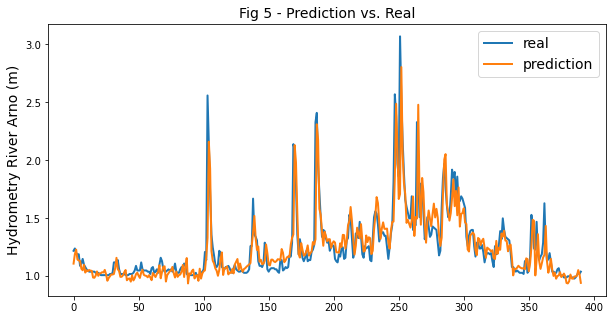

In [20]:
fig, ax = plt.subplots(1, figsize=(10,5))
ax.set_title('Fig 5 - Prediction vs. Real', fontsize=14)
ax.plot(model[2], label='real', linewidth=2)
ax.plot(model[3], label='prediction', linewidth=2)
ax.set_ylabel('Hydrometry River Arno (m)', fontsize=14)
ax.legend(loc='best', fontsize=14)
plt.show()


### Conclusion

We can see that the MAE and RSME calculated for the training data are higher than those calculated for the test data, this indicates that the model has a good generalization capacity and is not overfitted.

With small modifications it is possible to use this same approach for the other waterbodies, and it is also possible to vary the hyperparameters in order to decrease the model error.
